# Statistics 5: Slicing Arrays, Importing Files, and Working with LC/MS Data

We are now going to integrate some of the concepts we learned throughout the course to do some quantitative analysis of LC/MS data. The key to doing this is to learn how to slice arrays and import external files. This will allow you to really use the power of Python on your own data in the future. Let's start by importing the libraries we need.

In [50]:
import numpy as np
import matplotlib.pyplot as plt

## Importing and Analyzing High Resolution MS Data

We are going to import a spectrum of a small protein called [Ubiquitin](https://en.wikipedia.org/wiki/Ubiquitin). To do this, you need to download the "ubiquitin.txt" file from D2L and upload it into Gryd as you have done with this notebook file. This file has a list of m/z values in the first column and a list of intensity values in the second column.

m/z1 intensity1  
m/z2 intensity2  
...  ...

Once you have the file uploaded, you can use the numpy function np.loadtxt() to import the file. It will import it as a numpy array.

In [2]:
data = np.loadtxt("ubiquitin.txt") #Load the text file
print(data)
print(data.shape)

[[  6.00000125e+02   0.00000000e+00]
 [  6.04357705e+02   0.00000000e+00]
 [  6.04358836e+02   1.12750000e-02]
 ..., 
 [  1.79672065e+03   1.16290000e-02]
 [  1.79673064e+03   0.00000000e+00]
 [  1.79999439e+03   0.00000000e+00]]
(25811, 2)


You can see from the print(data.shape) command that this is an 25811 by 2 array. In other words, it has 25811 data points, each of which is a pair of m/z and intensity values. To extract values from this array, we use square brackets. To specify each dimension, we use commas. The colon symbol (:) without anything around it means take everything in this dimension. The colon symbol with a number in front of it (2:) means start at index 2 and take everything ahead of it. The colon symbol with a number after it (:5) means start at the beginning and stop before you hit index 5. A number before and after the colon starts at the first index and stops before the last index. Let's look at some examples:

In [3]:
print("Take the first data pair:", data[0])
print("Take the first m/z value:", data[0,0])
print("Take the third intensity value:", data[2,1])
print("Take the first column (the m/z values):", data[:,0])
print("Take the first three data pairs:", data[:3])
print("Take the third through the fifth data pairs:", data[2:5])
print("Take the fifth through the seventh m/z values:", data[4:6, 0])

Take the first data pair: [ 600.000125    0.      ]
Take the first m/z value: 600.000125
Take the third intensity value: 0.011275
Take the first column (the m/z values): [  600.000125   604.357705   604.358836 ...,  1796.720648  1796.730641
  1799.994386]
Take the first three data pairs: [[  6.00000125e+02   0.00000000e+00]
 [  6.04357705e+02   0.00000000e+00]
 [  6.04358836e+02   1.12750000e-02]]
Take the third through the fifth data pairs: [[  6.04358836e+02   1.12750000e-02]
 [  6.04359967e+02   1.14640000e-02]
 [  6.04361098e+02   1.16370000e-02]]
Take the fifth through the seventh m/z values: [ 604.361098  604.362228]


If the code above doesn't make sense, generate a simple array of your own and play around with slicing. Also, this [tutorial](https://www.geeksforgeeks.org/indexing-in-numpy/) may help.

The code below will show you some handy tricks to get specific data points, including maximum and minimum values. Here, we use the functions "argmax" and "argmin" to determine the indexes of the minimum or maximum values. If you want to find the nearest value to a search target, subtract everything by the target, take the absolute value, and find the minimum. This gives you the index that is closest. 

Index of Maximum: 8718
Most Intense Data Point: [ 857.480521    1.      ]
Closest data pair to 800 is: [ 800.02647    0.     ]


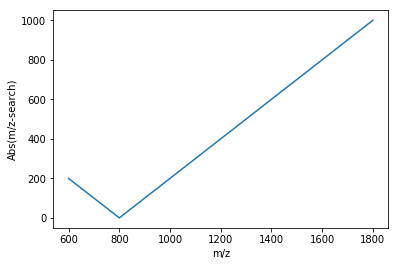

In [51]:
# Note: np.argmax() gives the index of the maximum value in an array
index_of_maximum = np.argmax(data[:,1]) # Take only the intensity values from the data; ignore the first column of m/z values.
print("Index of Maximum:", index_of_maximum)
# This code will give you the maximum value in the data set
print("Most Intense Data Point:", data[index_of_maximum])

#To find the closest value to a specific numer
mzsearch = 800
index = np.argmin(np.abs(data[:,0]-mzsearch))
print("Closest data pair to", mzsearch, "is:", data[index])

# Make a plot to show the concept
plt.plot(data[:,0], np.abs(data[:,0]-mzsearch))
plt.xlabel("m/z")
plt.ylabel("Abs(m/z-search)")
plt.show()

Ok, now we know how to plot this data. Let's take a look at it.

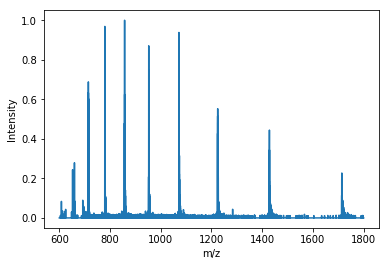

In [52]:
plt.plot(data[:,0], data[:,1]) # Plot the x and y columns of the data
plt.xlabel("m/z") #Label the x-axis
plt.ylabel("Intensity") #Label the y-axis
plt.show()

Let's grab the data chop function from Python 3 homework (slightly modified) and zoom in to look at some of these peaks more closely, specifically the range of the spectrum from 1070 to 1080 m/z. 

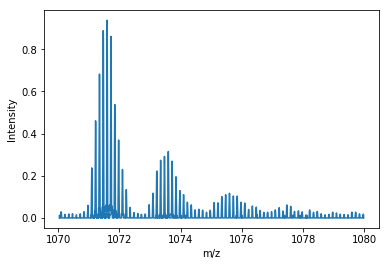

In [53]:
# Function to chop the data down between the new min and max values.
def datachop(data, minx, maxx):
    boo1 = np.logical_and(data[:,0] <= maxx, data[:,0] >= minx)
    return data[boo1]

#Select a specific region of the data
zoomdat=datachop(data, 1070,1080)

#Plot it
plt.plot(zoomdat[:,0], zoomdat[:,1])
plt.xlabel("m/z") #Label the x-axis
plt.ylabel("Intensity") #Label the y-axis
plt.show()


You can see that there are three Gaussian clusters of peaks. What are these? Let's zoom in a bit farther.

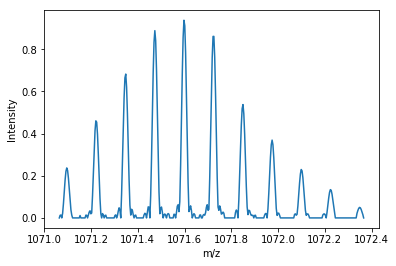

In [54]:
#Select a specific region of the data
zoomdat=datachop(data, 1071,1072.4)

#Plot it
plt.plot(zoomdat[:,0], zoomdat[:,1])
plt.xlabel("m/z") #Label the x-axis
plt.ylabel("Intensity") #Label the y-axis
plt.show()

What are these? They are different isotopes of the protein. We now need to figure out the charge state for this cluster of isotopes so we can determine the mass. To do this, let's write some code that can grab the peaks out of this data. We will define a peak detection function that takes the data as well as two parameters, the window and threshold. We define a peak as something that is the local maximum in a range of +/- the window. Here, the default is 10 data points. The peak also needs to be above a certain threshold to count. Here the default is 0.1, or 10%. Thus, a peak needs to be greater than 10% of the maximum in the data and larger than 10 data points on either side of it.

Peaks: [[  1.07109658e+03   2.37246000e-01]
 [  1.07122090e+03   4.60769000e-01]
 [  1.07134879e+03   6.82638000e-01]
 [  1.07147317e+03   8.88820000e-01]
 [  1.07159757e+03   9.38147000e-01]
 [  1.07172555e+03   8.61467000e-01]
 [  1.07185001e+03   5.37933000e-01]
 [  1.07197450e+03   3.69287000e-01]
 [  1.07209902e+03   2.29717000e-01]
 [  1.07222357e+03   1.34209000e-01]]


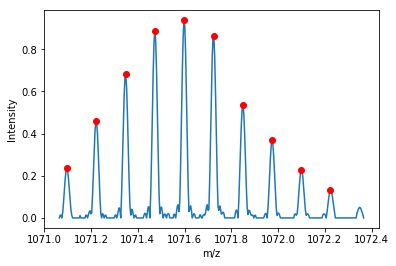

In [74]:
# Peak Detection Function.
def peak_detect(data, window=10, threshold=0.1):
    peaks = [] # Initialize the peaks array
    length = len(data) # Get the length of the data
    thresh = np.amax(data[:, 1]) * threshold # Set the threshold based on the maximum intensity value and the threshold ratio.
    for i in range(0, length): # Loop through all data points
        if data[i, 1] > thresh: # Check if the data point is greater than the threshold
            start = i - window # Set the lower half of the window
            end = i + window # Set the upper half of the window
            
            # Fix the window if it is at the edge of the array and convert to integers
            if start < 0: 
                start = 0
            if end > length:
                end = length

            # Get the max in the window
            testmax = np.amax(data[int(start):int(end), 1])
            
            # If the max is equal to the data point, add it to the peaks list
            if data[i, 1] == testmax:
                peaks.append([data[i, 0], data[i, 1]])
    # Return the peaks list
    return np.array(peaks)

#Select a specific region of the data
zoomdat=datachop(data, 1071,1072.4)
#Pick Peaks
peaks = peak_detect(zoomdat)
print("Peaks:", peaks)

#Plot it
plt.plot(zoomdat[:,0], zoomdat[:,1])
plt.xlabel("m/z") #Label the x-axis
plt.ylabel("Intensity") #Label the y-axis
#Mark each peak with a red circle
for p in peaks:
    plt.plot(p[0],p[1], color="red", marker="o")
plt.show()

**Problem 1:** Using the peaks array from above (reprinted below), **1)** find the charge state for this set of peaks and **2)** calculate the mass of the most abundant isotope. Important note: do this without retyping any of the numbers in the peaks array. I want you to automate this process. 

Hint: you will need to remember to subtract the mass of the proton when you calculate the mass. 

Hint 2: The function np.diff() will give you the differences between concecutive elements in an array.

In [79]:
#Select a specific region of the data
zoomdat=datachop(data, 1071,1072.4)
#Pick Peaks
peaks = peak_detect(zoomdat)

# Your Code Here


**Problem 2:** Ubiquitin has a molecular formula of $C_{378} H_{629} N_{105} O_{118} S_1$. Using the average mass values I've given you below, **1)** Calculate the average mass of ubiquitin and **2)** Calculate the ppm error for the measurement from problem 1. Would this pass a 10 ppm cutoff? **3)** Write an if statement to test if the ppm error is less than 10 ppm and print either "Ubiquitin" or "Not Ubiquitin". 

In [78]:
c = 12.0107
h = 1.00794
n = 14.0067
o = 15.9994
s = 32.065

# Your Code Here


Because the ppm error is very small, this particular peak at 1071.6 m/z is definitely the +8 ion of ubiquitin. What are the other peaks we are seeing? Let's look at the spectrum again.

**Problem 3:** Adjust the code below to get only three peaks with one around 1073.5 and another around 1075.5 m/z. You don't want every isotope, just the most abundant isotopes in each of the three Gaussian clusters. Calculate **1)** their masses and **2)** the difference in mass between the ubiquitin peak. 

Hint: you can assume these are all +8 charge state. 

Hint 2: The np.diff() function should come in handy here too. 

Hint 3: Try adjusting the window on the peak_detect function to get the peaks you want. 

In [77]:
#Select a specific region of the data
zoomdat=datachop(data, 1070,1080)

#Your Code Here


What do you think the difference between these peaks are? The difference is around 16 Da, so we can guess they are oxidations (the mass of oxygen is 16 Da). The protein gets oxidized and extra oxygen atoms are added to the molecule. In fact, this data is for a protein that has been exposed to hydrogen peroxide, so oxidation is quite likely. 

You could calculate the percentage oxidation from this single spectrum, but I'm not going to let you off the hook that easily. Let's look at some triple quad data that is time resolved to learn how to extract TIC and EIC plots. 

## Working with LC/MS Data

The next step is to upload the "lcms.csv" file from D2L to Gryd just like you did with the text file above. We will use the same loadtxt command but need to specify that it is a CSV file (comma separated variables).

Feel free to examine this file in Excel to get a sense for how it is structured.

In [58]:
data2 = np.loadtxt("lcms.csv", delimiter= ",")
print(data2.shape)

(110, 14610)


It will take a second to run, but it should import the data as a list of 110 by 14610. The first dimension is the retention time, and the second dimension is m/z. I've packaged the retention time values as the first column and the m/z values as the first row. The point (0,0) can be ignored. Let's extract them:

In [60]:
mz = data2[0, 1:] # Extract the m/z values from the array. 
time = data2[1:,0] # Extract the retention time values
ints = data2[1:, 1:] # Extract the intensity values
print(mz.shape, mz)
print(time.shape, time)
print(ints.shape)

(14609,) [  400.           400.06591797   400.13183594 ...,  2047.01123047
  2047.07714844  2047.93408203]
(109,) [  0.10152667   0.286355     0.471175     0.65600833   0.84084166
   1.02567501   1.21050832   1.39534167   1.58016499   1.76499166
   1.94982332   2.13464167   2.31947501   2.50430834   2.68914165
   2.87397499   3.05882001   3.24366667   3.42851334   3.61335835
   3.79819167   3.98302495   4.16785836   4.35268164   4.5375083
   4.72234168   4.90717497   5.09200835   5.27684169   5.46167498
   5.64650836   5.83134165   6.01616669   6.20099168   6.38582497
   6.57065501   6.755475     6.94030833   7.12514167   7.309975
   7.49480834   7.67964163   7.86445832   8.04929156   8.23411837
   8.41894159   8.60378504   8.78862495   8.97345829   9.15829172
   9.34312506   9.5279583    9.71279163   9.89762497  10.0824584
  10.26729164  10.45212498  10.63695498  10.82177496  11.0066083
  11.19144163  11.37626495  11.56107502  11.74590836  11.93074169
  12.11557493  12.30040836  12.48

The final intensity array should have one less row and one less column after we took out the axes. Now, let's learn how to make a 2D plot of the intensity values. We will use the contourf function in matplotlib to make a contour plot. 

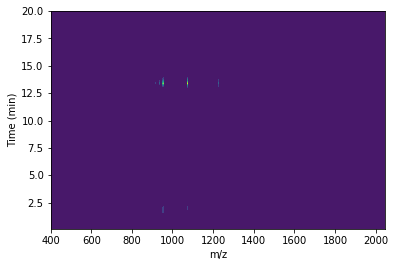

In [61]:
plt.contourf(mz, time, ints)
plt.xlabel("m/z")
plt.ylabel("Time (min)")
plt.show()

This is a little hard to see. You can only see a few major spots, and it's pretty small. Using the square root of the instensity can help the smaller peaks to come out:

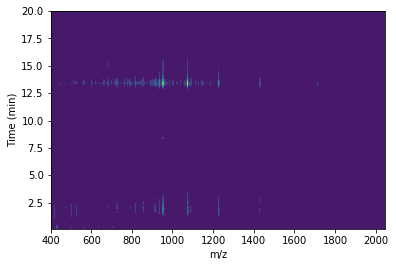

In [62]:
plt.contourf(mz, time, np.sqrt(ints))
plt.xlabel("m/z")
plt.ylabel("Time (min)")
plt.show()

It's still a bit hard to see, but you can start to make out that there is a series of peaks around 2.5 minutes and another around 13-14 minutes. Let's generate a total mass spectrum and a total ion chromatogram using the numpy sum command and summing across different axes of the intensity array. 

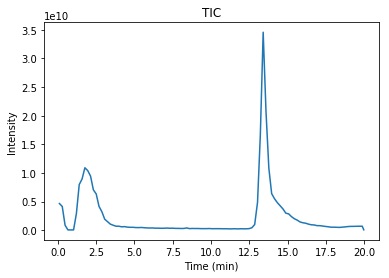

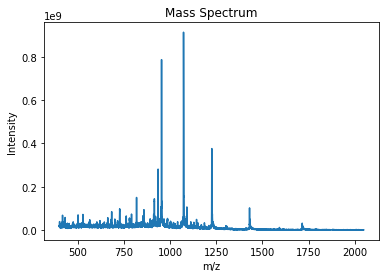

In [63]:
# Extract the TIC by summing along the m/z axis, the second dimension.
tic = np.sum(ints, axis=1)

#Plot it.
plt.figure()
plt.plot(time, tic)
plt.xlabel("Time (min)")
plt.ylabel("Intensity")
plt.title("TIC")


# Extract the total mass spectrum by summing along the time axis, the first dimension.
mzint = np.sum(ints, axis=0)

#Plot it.
plt.figure()
plt.plot(mz, mzint)
plt.xlabel("m/z")
plt.ylabel("Intensity")
plt.title("Mass Spectrum")
plt.show()


The top plot will show the total ion current (all m/z values) as a function of time while the bottom plot shows the total m/z spectrum summed over all retention times.

For quantitation, we want to make an extracted ion chromatogram. We can use the m/z values we determined above. For example, we should have a peak at 1071.6 m/z. Let's zoom into that region of the mass spetrum to compare the data against the high resolution data. I will normalize both sets of data to a maximum of 1 to help compare the two.

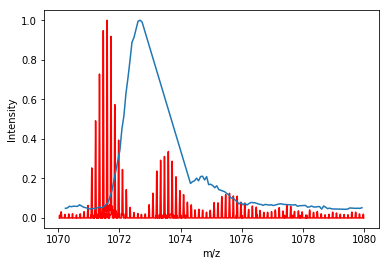

In [64]:
# Let's repackage the total m/z data from the LC/MS back togehter into an n x 2 array.
mzdata =np.transpose([mz, np.sum(ints, axis=0)])

#Select a specific region of the data
zoomdat2=datachop(mzdata, 1070,1080)
# Normalize the data by dividing by the maximum
zoomdat2[:,1] /= np.amax(zoomdat2[:,1])

#Select a specific region of the data
zoomdat=datachop(data, 1070,1080)
# Normalize the data by dividing by the maximum
zoomdat[:,1] /= np.amax(zoomdat[:,1])

#Plot it
plt.plot(zoomdat[:,0], zoomdat[:,1], color="r")
plt.plot(zoomdat2[:,0], zoomdat2[:,1])
plt.xlabel("m/z") #Label the x-axis
plt.ylabel("Intensity") #Label the y-axis
plt.show()

Ouch! The low resolution spectrum is not really able to resolve the oxidized peaks. Furthermore, it is poorly calibrated, which is causing a systematic shift to around 1 m/z higher than it should be. Now, it is important to note the the blue spectrum was collected on an instrument that cost around 50,000 dollars that was built in 2005 while the red spectrum was collected on an instrument that cost over 1,500,000 dollars and was built in 2019. So, you can't fault the instrument for it's poor resolution. However, the calibration error is definitely something the operater should have noticed and fixed. 

Let's see if we can find a better region of the spectrum at the +7 charge state around 1,230 m/z.

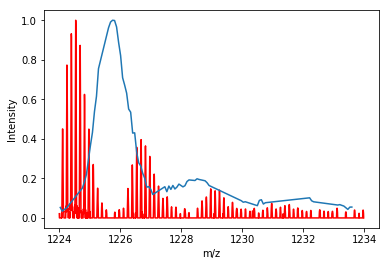

In [65]:
# Repackage the total m/z data from the LC/MS back togehter into an n x 2 array.
mzdata =np.transpose([mz, np.sum(ints, axis=0)])

#Select a specific region of the data
zoomdat2=datachop(mzdata, 1224,1234)
# Normalize the data by dividing by the maximum
zoomdat2[:,1] /= np.amax(zoomdat2[:,1])

#Select a specific region of the data
zoomdat=datachop(data, 1224,1234)
# Normalize the data by dividing by the maximum
zoomdat[:,1] /= np.amax(zoomdat[:,1])

#Plot it
plt.plot(zoomdat[:,0], zoomdat[:,1], color="r")
plt.plot(zoomdat2[:,0], zoomdat2[:,1])
plt.xlabel("m/z") #Label the x-axis
plt.ylabel("Intensity") #Label the y-axis
plt.show()

The calibration is stilll off, but you can more clearly see the main peak 1226 and the oxidized peak around 1228.25. Let's create an extracted ion chromatogram for the first peak:

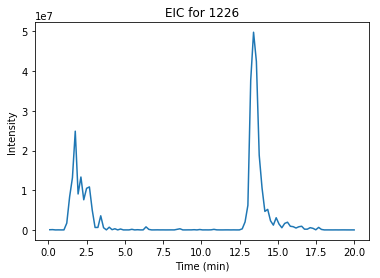

In [66]:
# First, find the index of the m/z value closet to 1226
mzindex = np.argmin(np.abs(mz-1226))

#Next, slice this out of the intensity array
eic = ints[:, mzindex]


#Plot it
plt.plot(time, eic)
plt.xlabel("Time (min)")
plt.ylabel("Intensity")
plt.title("EIC for 1226")
plt.show()

It's a bit noisy, so let's sum up a few nearby data points. In other words, rather than just taking one slice, lets sum together a few slices:

9724


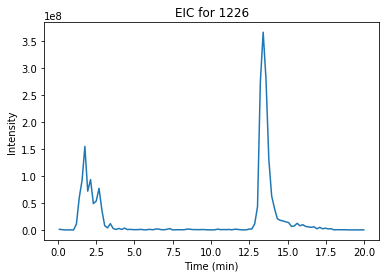

In [67]:
# First, find the index of the m/z value closet to 1226
mzindex = np.argmin(np.abs(mz-1226))

#Next, slice this out of the intensity array
start = mzindex-3 # Start three points below the index
end = mzindex+4 # End three points above the index
eic = np.sum(ints[:, start:end], axis=1) # Sum together the slice
print(mzindex)

#Plot it
plt.plot(time, eic)
plt.xlabel("Time (min)")
plt.ylabel("Intensity")
plt.title("EIC for 1226")
plt.show()

You can see here that some protein doesn't stick to the column but comes through with the mobile phase around 2 minutes. We want to ignore this signal because it can suffer from matrix effects with salt adduction. However, much of it does bind appropriately and come out around 13 minutes. Let's integrate under that peak to quantiate the percent oxidation. 

**Problem 4:** **1)** Create an extracted ion chromatogram for the m/z value that is 16 Da larger than the main peak at 1,226. Plot this EIC at on the same plot as the EIC for 1226 that we plotted above. Hint: you will need to add 16/7 to the peak because the charge state is +7. 

**2)** Using the code from Python Homework 3, integrate under the EIC from 10 to 17.5 minutes for both the oxidized and unoxidized. Print the percent oxidation from the two peak areas, which is oxidized/(oxidized + unoxidized)*100.

In [76]:
# Your code here


You should find that the retention time from the EICs is similar for both the oxidized and unoxidized species. I got an answer of around 16% Oxidation. 

## Conclusion

This wraps up our Python tutorials. You have learned some fundamental programming concepts like the key Python syntax, writing functions, using if and for statements. You have also learned some important data analysis skills like how to import, manipulate, and plot arrays. Finally, you have learned some fundamental concepts in analytical chemistry like calibration curves, standard addition, internal standards, peak integration, and statistics. Well done!

I hope these skills are useful for you in your future career in science! Happy coding!

In [73]:
print("Peace out...")

Peace out...
